# Import packages

In [1]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from turtle import color
from matplotlib.lines import lineStyles 

# directory setting

In [2]:
!git clone https://github.com/rhfo3218/LG_ML_tutorial.git
import os
os.chdir('/content/LG_ML_tutorial/8. Example_1_Concrete')

In [3]:
# load data
concrete = pd.read_csv('Concrete_cleaned.csv')
dataset = np.array(concrete)

In [4]:
# age transform (log scail)
dataset[:,7] = np.log(dataset[:,7])

# min-max normalize
scaler = MinMaxScaler()
scaler.fit(dataset)

maxs = scaler.data_max_
mins = scaler.data_min_

dataset = scaler.transform(dataset)
data_X = dataset[:,0:8]
data_y = dataset[:,8]


In [5]:
# train-test split
n_train = round(0.7*data_X.shape[0])
tr_X, ts_X, tr_Y, ts_Y = train_test_split(data_X, data_y, train_size=n_train)

In [6]:
# model learning
lr_model = LinearRegression()
lr_model.fit(tr_X,tr_Y)

NN_model = MLPRegressor(solver = 'lbfgs', batch_size= 300, max_iter=20000, alpha=1e-2, hidden_layer_sizes=(10,8,))
NN_model.fit(tr_X,tr_Y)


MLPRegressor(alpha=0.01, batch_size=300, hidden_layer_sizes=(10, 8),
             max_iter=20000, solver='lbfgs')

In [64]:
# show predict result of each model
lr_pred = lr_model.predict(ts_X)
NN_pred = NN_model.predict(ts_X)

# re-scaling
true_y = ts_Y*(maxs[8]- mins[8]) + mins[8]
lr_pred_y = lr_pred*(maxs[8]- mins[8]) + mins[8]
NN_pred_y = NN_pred*(maxs[8]- mins[8]) + mins[8]

# measure
lr_mse = mean_squared_error(lr_pred_y,true_y)
lr_mae = mean_absolute_error(lr_pred_y,true_y)
lr_r2 = r2_score(lr_pred_y,true_y)
NN_mse = mean_squared_error(NN_pred_y,true_y)
NN_mae = mean_absolute_error(NN_pred_y,true_y)
NN_r2 = r2_score(NN_pred_y,true_y)

print('linearRegression mse = ', np.round(lr_mse,3),'mae = ', np.round(lr_mae,3),'R-squared = ',np.round(lr_r2,3))
print('Neural Network   mse = ', np.round(NN_mse,3),'mae = ', np.round(NN_mae,3),'R-squared = ',np.round(NN_r2,3))

linearRegression mse =  50.362 mae =  5.494 R-squared =  0.789
Neural Network   mse =  33.008 mae =  4.305 R-squared =  0.877


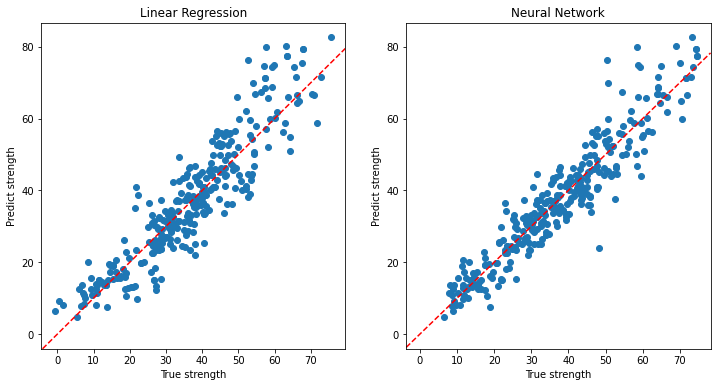

In [66]:
from matplotlib.pyplot import subplot
# scatter plot
plt.figure(figsize=(12,6))
subplot(1,2,1)
plt.scatter(lr_pred_y,true_y)
plt.plot(lr_pred_y, lr_pred_y, color = 'red', ls = '--', label = 'x=y')
plt.title("Linear Regression")
plt.xlabel('True strength')
plt.ylabel('Predict strength')
subplot(1,2,2)
plt.scatter(NN_pred_y,true_y)
plt.plot(NN_pred_y, NN_pred_y, color = 'red', ls = '--', label = 'x=y')
plt.title("Neural Network")
plt.xlabel('True strength')
plt.ylabel('Predict strength')
plt.show()

## The optimization problem we have to solve.

We have to make the Concrete that compression strength is over 50.

We have Blast Furnace Slag, Fly ash, but don't have Superplastizer.

And our due date is 28 days left.

And Cement is 10 times more expensive than Agrregate(Coarse, Fine).


**(Question) Find the quantities of each components which satisties the condition**

In [135]:
# -------------------------------------------------------------------------------------- #
# loss function
#   input
#              model: prediction models( linear regression, neural network)
#       x.values.all: predictor variable values, some of those are given,
#                     those corresponding to idx will change during optimization procedure
#             target: we want to get x.opt values such that the response reaches at this value
#              x.opt: predictor variable values to be optimized
#                idx: indices corresponding to x.opt variables
#
#   output
#               loss: loss function value (we want to minimize this)
#
# CREATED 10/19/2022 by Hyunho Kim
# -------------------------------------------------------------------------------------- #

def loss_fun(x_opt, model, x_values_all, target, idx ):
  x_values_all[:,idx] = x_opt
  pred = model.predict( x_values_all )
  loss = (pred - target)**2 # squared loss function
  #loss_str = (pred - target)**2 # squared loss function
  #loss_cost = 10*x_opt[0] + x_opt[1] + x_opt[2]
  #loss = 1000000*loss_str + loss_cost
  return(loss)

In [136]:
# set other components (given) 
columns = ['Cement','Blast Furnace Slag','Fly Ash','Water','Superplasticizer','Coarse Aggregate','Fine Aggregate', 'Age (day)']
target_norm = (50-mins[8])/(maxs[8]-mins[8])  # Compression strength 50 
age_norm = (np.log(28)-mins[7])/(maxs[7]-mins[7])  # age is 28 (given)
ash_norm = (50-mins[2])/(maxs[2]-mins[2]) # flyash is 2 (given)
slag_norm = (80-mins[1])/(maxs[1]-mins[1]) # flyash is 2 (given)
plastizer_norm = (0-mins[4])/(maxs[4]-mins[4]) # plastizer is 0 (given)

In [139]:
# make sample data row
sample_row = np.array(concrete)[200,:-1] # dummy row
sample_row[1] = slag_norm
sample_row[2] = ash_norm
sample_row[4] = plastizer_norm
sample_row[7] = age_norm

In [152]:
# find optimal point
from scipy import optimize

x0 = np.random.uniform(0,1,4).reshape(1, -1)
sample_row = sample_row.reshape(1, -1)
bounds = optimize.Bounds([0,0,0,0],[1,1,1,1])
res = optimize.minimize(loss_fun,x0,args=(lr_model,sample_row,target_norm,np.array([0,3,5,6])),method='L-BFGS-B', bounds=bounds,options={'disp': True})

In [153]:
# linear model
sample_row[:,0] = res.x[0]
sample_row[:,3] = res.x[1]
sample_row[:,5] = res.x[2]
sample_row[:,6] = res.x[3]
target_hat = lr_model.predict(sample_row)
orig_target_hat = target_hat* (maxs[8]-mins[8]) + mins[8]


# answer 
opt_Cement = res.x[0] * (maxs[0]-mins[0]) + mins[0] 
opt_Water = res.x[1] * (maxs[3]-mins[3]) + mins[3] 
opt_Coarse_Aggregate = res.x[2] * (maxs[5]-mins[5]) + mins[5]
opt_Fine_Aggregate = res.x[3] * (maxs[6]-mins[6]) + mins[6]
print("Optimal settings")
print("Cement = ",np.round(opt_Cement,2),"(kg/m3)")
print("Water = ",np.round(opt_Water,2),"(kg/m3)")
print("Coarse_Aggregate = ",np.round(opt_Coarse_Aggregate,2),"(kg/m3)")
print("Fine_Aggregate = ",np.round(opt_Fine_Aggregate,2),"(kg/m3)")
print("found Concrete Compression Strength = ",np.round(orig_target_hat,2),"Mpa")

Optimal settings
Cement =  371.95 (kg/m3)
Water =  196.94 (kg/m3)
Coarse_Aggregate =  998.86 (kg/m3)
Fine_Aggregate =  855.62 (kg/m3)
found Concrete Compression Strength =  [50.] Mpa


In [154]:
# neural network
sample_row[:,0] = res.x[0]
sample_row[:,3] = res.x[1]
sample_row[:,5] = res.x[2]
sample_row[:,6] = res.x[3]
target_hat = NN_model.predict(sample_row)
orig_target_hat = target_hat* (maxs[8]-mins[8]) + mins[8]

# answer 
opt_Cement = res.x[0] * (maxs[0]-mins[0]) + mins[0] 
opt_Water = res.x[1] * (maxs[3]-mins[3]) + mins[3] 
opt_Coarse_Aggregate = res.x[2] * (maxs[5]-mins[5]) + mins[5]
opt_Fine_Aggregate = res.x[3] * (maxs[6]-mins[6]) + mins[6]
print("Optimal settings")
print("Cement = ",np.round(opt_Cement,2),"(kg/m3)")
print("Water = ",np.round(opt_Water,2),"(kg/m3)")
print("Coarse_Aggregate = ",np.round(opt_Coarse_Aggregate,2),"(kg/m3)")
print("Fine_Aggregate = ",np.round(opt_Fine_Aggregate,2),"(kg/m3)")
print("found Concrete Compression Strength = ",np.round(orig_target_hat,2),"Mpa")

Optimal settings
Cement =  371.95 (kg/m3)
Water =  196.94 (kg/m3)
Coarse_Aggregate =  998.86 (kg/m3)
Fine_Aggregate =  855.62 (kg/m3)
found Concrete Compression Strength =  [43.1] Mpa


In [156]:
x1 = np.linspace(mins[0],maxs[0],50)
x2 = np.linspace(mins[5],maxs[5],50)
X = np.array(np.meshgrid(x1,x2)).reshape(2,50*50).T
dt = np.repeat(sample_row, repeats= 2500, axis = 0)
dt[:,0] = (X[:,0]-mins[0])/(maxs[0]-mins[0])
dt[:,5] = (X[:,1]-mins[5])/(maxs[5]-mins[5])
Y = lr_model.predict(dt).reshape(50,50)
Y = Y*(maxs[8] - mins[8]) + mins[8]

Cement(kg/m3) =  371.95
Coarse Aggregate(kg/m3) =  998.86


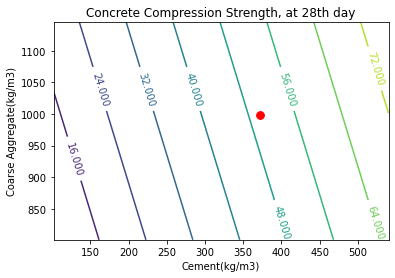

In [158]:
# Draw contour plot
fig, ax = plt.subplots()
CS = ax.contour(x1, x2, Y,levels=10)
ax.clabel(CS, inline=1, fontsize=10)

ax.scatter(opt_Cement,opt_Coarse_Aggregate,c='r',s=60)
ax.set_title('Concrete Compression Strength, at 28th day')
ax.set_xlabel('Cement(kg/m3)')
ax.set_ylabel('Coarse Aggregate(kg/m3)')
print("Cement(kg/m3) = ",round(opt_Cement,2))
print("Coarse Aggregate(kg/m3) = ",round(opt_Coarse_Aggregate,2))


Text(0.5, 0, 'age')

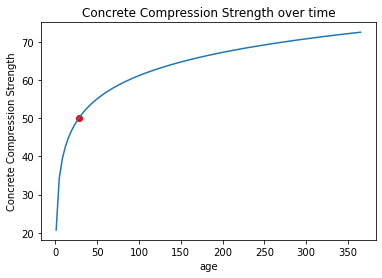

In [160]:
# Concrete Compression Strength 
age_l = np.linspace(np.exp(mins[7]),np.exp(maxs[7]),100)
dt = np.repeat(sample_row, repeats= 100, axis = 0)
dt[:,7] = (np.log(age_l)-mins[7])/(maxs[7]-mins[7])
Y = lr_model.predict(dt)
Y = Y*(maxs[8] - mins[8]) + mins[8]
plt.plot(age_l,Y)
plt.scatter(28,50,color = 'r')
plt.title("Concrete Compression Strength over time")
plt.ylabel("Concrete Compression Strength")
plt.xlabel("age")